# Optimizing Model Prediction

In this project I'd like to practice several techniques to optimize a linear regression model (the techniques however are also transferable to other models).  We will use a dataset from the UCI Machine Learning Repository, the Forest Fires dataset (https://archive.ics.uci.edu/ml/datasets/Forest+Fires). The dataset contains information on fires, along with the resulting damage and associated meteorological data. Our machine learning task will be to predict the damage to a forest from the given data:

- X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- month - month of the year: 'jan' to 'dec'
- day - day of the week: 'mon' to 'sun'
- FFMC - FFMC (Fine Fuel Moisture Code) from the FWI (Fire Weather Index) represents fuel moisture of forest litter fuels under the shade of a forest canopy: 18.7 to 96.20
- DMC - DMC (Duff Moisture Code) from the FWI system represents fuel moisture of decomposed organic material underneath the litter: 1.1 to 291.3
- DC - DC (Drought Code) index from the FWI system represents drying deep into the soil: 7.9 to 860.6
- ISI - ISI (Initial Spread Index) from the FWI system integrates fuel moisture for fine dead fuels and surface windspeed to estimate a spread potential: 0.0 to 56.10
- temp - temperature in Celsius degrees: 2.2 to 33.30
- RH - relative humidity in %: 15.0 to 100
- wind - wind speed in km/h: 0.40 to 9.40
- rain - outside rain in mm/m2 : 0.0 to 6.4
- area - the burned area of the forest (in ha): 0.00 to 1090.84

In [511]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

In [512]:
fires = pd.read_csv("fires.csv")
fires.info()
fires.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


## Data cleaning

Even at first glance it is evident that many values are missing and that the date columns are not in numerical form. So let's start with data cleaning.

### coordinates X and Y

The specific location in the national park isn't interesting for our general approach, so we drop them. We alo don't need the first column (enumerating integer).

In [513]:
fires = fires.drop(["Unnamed: 0","X","Y"], axis=1)

### month and date

In [514]:
fires["day"].value_counts()

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

In [515]:
fires["month"].value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

Most fires seems to haben around the weekend and in late summer (august, september). So there is definitely a time-dependent course. However, the reasons for fires are more likely to be explained by the weather and soil conditions which we also have in our data. So we simply drop these columns. In order to use them anyway we would have to convert it into a numerical form (e.g. with OneHotEncoder). 

In [516]:
fires = fires.drop(["day","month"], axis=1)

### weather and soil conditions

These are the data we like to keep, but every column has missing values. To fix and don't loose many rows from the very limited dataset we have to impute them with assumed values. One approach would be to replace the values with the mean of all the observations, but it seems smarter to replace them by values of similar obserations. KNNImputer can do this by looking for the k nearest (most similar) neighbors (observations) and take their mean value.

In [517]:
imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

imputed_fires = pd.DataFrame(imp.fit_transform(fires[fires.columns[:-1]]), columns = fires[fires.columns[:-1]].columns)

imputed_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FFMC    517 non-null    float64
 1   DMC     517 non-null    float64
 2   DC      517 non-null    float64
 3   ISI     517 non-null    float64
 4   temp    517 non-null    float64
 5   RH      517 non-null    float64
 6   wind    517 non-null    float64
 7   rain    517 non-null    float64
dtypes: float64(8)
memory usage: 32.4 KB


It's important to also look for outliers that could have disturbing effects to the model. We will observe each boxplot, but also calculate the upper and lower bound by multiplying the interquartile range by 1.5.

<AxesSubplot:>

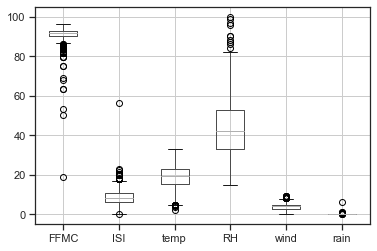

In [518]:
imputed_fires.boxplot(column=["FFMC", "ISI", "temp", "RH", "wind", "rain"])

<AxesSubplot:>

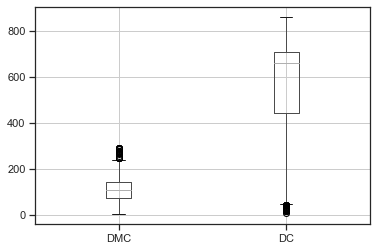

In [519]:
imputed_fires.boxplot(column=["DMC", "DC"])

In [520]:
for col in imputed_fires:
    quartiles = np.percentile(imputed_fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers = sum((imputed_fires[col] < lower_bound) | (imputed_fires[col] > upper_bound))

    print(f"The {col} column has {num_outliers} outliers.")

The FFMC column has 53 outliers.
The DMC column has 22 outliers.
The DC column has 25 outliers.
The ISI column has 23 outliers.
The temp column has 9 outliers.
The RH column has 10 outliers.
The wind column has 13 outliers.
The rain column has 8 outliers.


There in fact some outliers. We'll leave them in for now and will later compare whether the model is better with or without them. Later we will also test whether standardizing the data has a positive effect.

### target value area

Examining the distribution of the target variable is very important for our model. For linear regression, we should have a normal distribution at best.

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

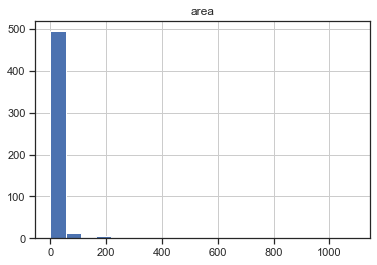

In [521]:
fires.hist("area", bins=20)

<AxesSubplot:>

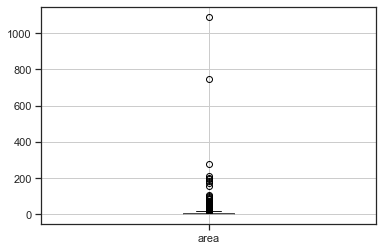

In [522]:
fires.boxplot(column=["area"])

In [523]:
quartiles = np.percentile(fires["area"], [25, 50, 75])
iqr = quartiles[2] - quartiles[0]
lower_bound = quartiles[0] - (1.5 * iqr)
upper_bound = quartiles[2] + (1.5 * iqr)
num_outliers = sum((fires["area"] < lower_bound) | (fires["area"] > upper_bound))

print(f"The area column has {num_outliers} outliers.")

The area column has 63 outliers.


Unfortunaly the distribution is highly right-skewed with extremely damaging fires. Also, most fires do very little damage (even 0 ha). Not a good basis for our model. By taking a logarithm of the data, we may be able to improve the distribution somewhat. Wie have to add a little value to the area, because it is not possible to take logarithm from 0.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

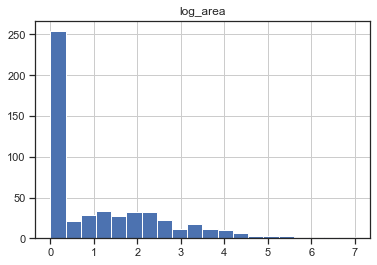

In [524]:
imputed_fires["log_area"] = np.log(fires["area"] + 1)

imputed_fires.hist("log_area", bins=20)

Interestingly, this gives us an better distribution for the large fires. But most of the fires are far from that. Unfortunately, we cannot simply remove this data as we would greatly overestimate the size of the fires. Maybe we will find a connection later that will enable us to separate the data into two different models. However, we will continue with this for the initial model.

## Initial model

To show how to improve a model we create our first reference model with all the data we recently cleaned.

In [525]:
reference_model = LinearRegression()

X = imputed_fires.drop("log_area", axis=1)
y = imputed_fires["log_area"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
reference_model.fit(X_train, y_train)
reference_model.score(X_train, y_train)

0.01898360768263685

The prediction power of our initial model is close to zero. Let's see if we can improve it by simple measures like standardizing the feature values or drop the outliers.

#### standardizing features

In [526]:
scaler = StandardScaler()

standardized_X = scaler.fit_transform(X_train)

reference_model.fit(standardized_X, y_train)
reference_model.score(standardized_X, y_train)

0.01898360768263685

There isn't an effect at all. So we leave the features as they are.

#### drop outliers

In [527]:
print(imputed_fires.shape)

droped_fires = imputed_fires.copy()

for col in imputed_fires[imputed_fires.columns[:-1]]:
    quartiles = np.percentile(imputed_fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)    
    droped_fires = droped_fires.drop(imputed_fires[(imputed_fires[col] < lower_bound) | (imputed_fires[col] > upper_bound)].index, errors="ignore")
    
print(droped_fires.shape)

(517, 9)
(389, 9)


In [528]:
outliers_model = LinearRegression()

X_droped = droped_fires.drop("log_area", axis=1)
y_droped = droped_fires["log_area"]

X_train_droped, X_test_droped, y_train_droped, y_test_droped = train_test_split(X_droped, y_droped, test_size=0.25, random_state=1)

outliers_model.fit(X_train_droped,y_train_droped)
outliers_model.score(X_train_droped,y_train_droped)

0.021987475725616434

We droped nearly a quarter of our observations and got only a very little improvement. Droping outliers isn't the way we have to go here.

## Feature Selection

To select promising features we have to look for relationships with the target column.

<AxesSubplot:>

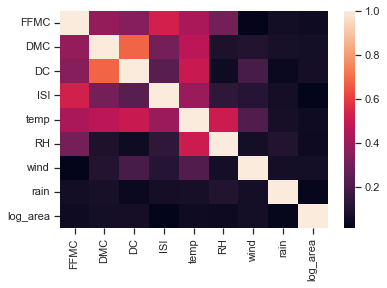

In [529]:
sns.heatmap(abs(imputed_fires.corr()))

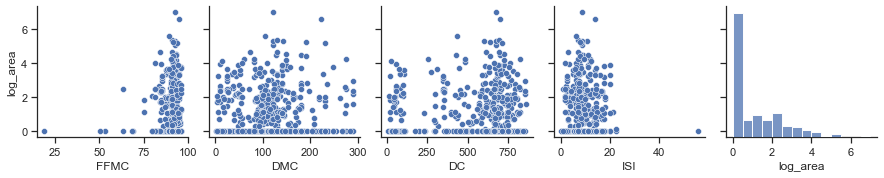

In [530]:
sns.pairplot(imputed_fires[["FFMC", "DMC", "DC", "ISI", "log_area"]], y_vars=["log_area"])

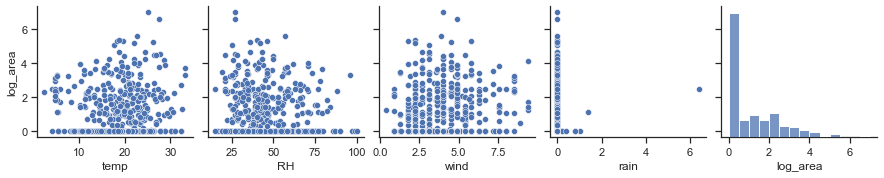

In [531]:
sns.pairplot(imputed_fires[["temp", "RH", "wind", "rain", "log_area"]], y_vars=["log_area"])

Unfortunately, as the poor model results suggested, there is no linear correlation between the variables and the size of the fire. Any other higher-dimensional relationships cannot be recognized either at first glance. Even though we will probably no longer be able to optimize the model satisfactorily, we will use this project to demonstrate further techniques.

There are quite a few features in the dataset, so let's use sequential feature selection to determine which features might be most useful.

In [532]:
model_sfs = LinearRegression()
model_comp = LinearRegression()

print("R²    features")

for i in range(1,len(X.columns)):
    sfs = SFS(model_sfs, n_features_to_select=i, direction='forward', scoring="r2")
    sfs.fit(X_train,y_train)
    var_sfs = sfs.get_feature_names_out()
    
    X_var = X_train[var_sfs]
    model_comp.fit(X_var,y_train)
    y_pred = model_comp.predict(X_var)
    r2_train = r2_score(y_train, y_pred)   
        
    print(round(r2_train,4), var_sfs)

R²    features
0.0053 ['rain']
0.0099 ['RH' 'rain']
0.0123 ['RH' 'wind' 'rain']
0.0174 ['DC' 'RH' 'wind' 'rain']
0.0177 ['FFMC' 'DC' 'RH' 'wind' 'rain']
0.018 ['FFMC' 'DMC' 'DC' 'RH' 'wind' 'rain']
0.0183 ['FFMC' 'DMC' 'DC' 'temp' 'RH' 'wind' 'rain']


A clear statement cannot be made here. Each feature adds a little something to the very low predictive power. In order not to overfit the model, we will test beneath combinations in our final evaluation.

In [533]:
sfs2_model = LinearRegression()
sfs2_cols = ['FFMC', 'rain']

sfs4_model = LinearRegression()
sfs4_cols = ['FFMC', 'DC', 'temp', 'rain']

sfs6_model = LinearRegression()
sfs6_cols = ['FFMC', 'DMC', 'DC', 'temp', 'wind', 'rain']

## Regularized models

Regularization is the process of simplifying a model so that it generalizes better to unseen data. One way we can regularize a model is to reduce the magnitude of the coefficients in a model. This is potentially useful in high-dimensional contexts because we need a way to narrow down the feature set. Even that is not the case here we take a look how this two variants perform:

- Ridge regression implements a penalty term in the loss function to reduce coefficient magnitude.
- LASSO also incorporates a penalty term, but its penalty also enables feature selection.

Standardization is essential for regularized models because we need to make sure that each of the coefficients are penalized similarly.

In [534]:
scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)

ridge_model = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso_model = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge_model.fit(standardized_X, y)
lasso_model.fit(standardized_X, y)

print("Ridge tuning parameter: ", ridge_model.alpha_)
print("LASSO tuning parameter: ", lasso_model.alpha_)

print("Ridge coefficients: ", ridge_model.coef_)
print("LASSO coefficients: ", lasso_model.coef_)

print("Ridge R²: ", ridge_model.score(standardized_X,y).round(2))
print("LASSO R²: ", lasso_model.score(standardized_X,y).round(2))

Ridge tuning parameter:  2142.927927927928
LASSO tuning parameter:  10000.0
Ridge coefficients:  [ 0.0098721   0.01439527  0.01484008 -0.00668233  0.00967847 -0.01091083
  0.01837577  0.00585511]
LASSO coefficients:  [ 0.  0.  0. -0.  0. -0.  0.  0.]
Ridge R²:  0.01
LASSO R²:  0.0


The LASSO tuning parameter goes to an extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. That is not  helpful at all and shows one again that this subject is hard to model. In our final evaluation we will use the ridge regression.

## Non-linear models

###  Polynomial features

Since linear models do not seem to help us here, we also try a polydimensional approach. Sklearn has a preprocessing class called PolynomialFeatures that generates a feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.

In [535]:
poly_model = LinearRegression()

poly = PolynomialFeatures(degree=2)

poly_X = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_X, y, test_size=0.25, random_state=1)

poly_model.fit(X_train, y_train)
poly_model.score(X_train, y_train)

0.06768455160567666

For the first time we may have a real optimization of the model even when it is still very weak. After some try around polynomial features of second degree seem to be the choice. Third degree performed weaker and with higher degree we overfit the model way too much.

### Piecewise functions / Splines

Piecewise functions can use different functions for different regions of the predictor. Spline models are piecewise polynomials that incorporate constraints to be continuous and smooth at the knot points (where the predictor function changes in the spline model). Spline models can be represented as a linear combination of basis functions. These basis functions are functions of the original predictor. To fully characterize a spline, we only need to create and calculate basis functions, which thankfully the SplineTransformer class can do for us.

In [536]:
spline_model = LinearRegression()

spline = SplineTransformer(degree=2, n_knots=2, knots="uniform")

spline_X = spline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(spline_X, y, test_size=0.25, random_state=1)

spline_model.fit(X_train, y_train)
spline_model.score(X_train, y_train)

0.05295116294885638

Since no extreme improvement can be seen or expected here either, we simply take the model with degree 2 and 2 knots into further consideration.

## K-Fold Cross-Validation

Now that we have a few candidate models, let's evaluate all of them using k-fold cross-validation. It will give us a better idea about model performance on unseen datasets compared to a single train-test split. 

In [537]:
reference_cv = cross_val_score(reference_model, X, y, cv = 5, scoring = "r2")
sfs2_cv = cross_val_score(sfs2_model, X[sfs2_cols], y, cv = 5, scoring = "r2")
sfs4_cv = cross_val_score(sfs4_model, X[sfs4_cols], y, cv = 5, scoring = "r2")
sfs6_cv = cross_val_score(sfs6_model, X[sfs6_cols], y, cv = 5, scoring = "r2")
ridge_cv = cross_val_score(ridge_model, standardized_X, y, cv = 5, scoring = "r2")
poly_cv = cross_val_score(poly_model, poly_X, y, cv = 5, scoring = "r2")
spline_cv = cross_val_score(spline_model, spline_X, y, cv = 5, scoring = "r2")

In [538]:
print("Reference Model, Avg R²: ", np.mean(reference_cv))
print("Forward-2 Model, Avg R²: ", np.mean(sfs2_cv))
print("Forward-4 Model, Avg R²: ", np.mean(sfs4_cv))
print("Forward-6 Model, Avg R²: ", np.mean(sfs6_cv))
print("Ridge Model, Avg R²: ", np.mean(ridge_cv))
print("Polynominal Model, Avg R²: ", np.mean(poly_cv))
print("Spline Model, Avg R²: ", np.mean(spline_cv))

Reference Model, Avg R²:  -0.23441788924761217
Forward-2 Model, Avg R²:  -0.17141210606107077
Forward-4 Model, Avg R²:  -0.2024113722679636
Forward-6 Model, Avg R²:  -0.2676636375304915
Ridge Model, Avg R²:  -0.11523137747715753
Polynominal Model, Avg R²:  -1.0065133961902224
Spline Model, Avg R²:  -12.84186132068975


Among our candidate models, the ridge model performs the best, with an R² of -0.115. A negativ R² means that it would be more accurate to just predict the mean of all area values than to use the model. We should also visualize how the model predictions compare against the actual observed values in the data. It may be the case that our model performs well on a particular subset.

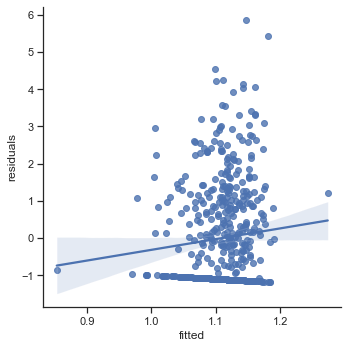

In [549]:
y_pred = ridge_model.predict(standardized_X)

check_model = pd.DataFrame()
check_model["residuals"] = y - y_pred
check_model["fitted"] = y_pred

sns.lmplot(x = 'fitted', y = 'residuals', data=check_model, palette='Set1')

There aren't clear trends or patterns in the performance of the model. It's clear that linear regression isn't capable of this problem and maybe no other model will be. However, this issue is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. This showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction very difficult.